### Implementation of RF in credit card fault detection

In [2]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import tensorboard

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib notebook
from sklearn.metrics import accuracy_score, auc, balanced_accuracy_score, confusion_matrix, f1_score, precision_score, average_precision_score, roc_auc_score,  recall_score,  precision_recall_curve #some scoring functions

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest, RandomForestClassifier # Some classifiers
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split #Cross validation tools, and a train/test split utility
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV #Hyper parameter search tools
# from hyperopt import hp, tpe, STATUS_OK, fmin, Trials #Hyperparameter search using a loss function 
# misc
import random as rn

In [56]:
df = pd.read_csv('creditcard.csv')

In [57]:
# Separate the input features and target
X = df.iloc[:, 1:30]
y = df.iloc[:, 30:31]

In [59]:
# split the dataset and see the splits
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.25)
training_fraud = sum(y_train.values)
training_fraud_pct = sum(y_train.values)/len(y_train.values)*100
test_fraud = sum(y_test.values)
test_fraud_pct = sum(y_test.values)/len(y_test.values)*100
print("X train: {}\nX test:  {}\ny_train: {}\ny test:  {} \nFraud in train set: {},   {:2f}%\nFraud in test set:  {},  {:2f}%\n".format( X_train.shape, 
                                                                                                                      X_test.shape, 
                                                                                                                      y_train.shape, 
                                                                                                                      y_test.shape, 
                                                                                                                      training_fraud[0], training_fraud_pct[0],
                                                                                                                      test_fraud[0], test_fraud_pct[0]))

X train: (213605, 29)
X test:  (71202, 29)
y_train: (213605, 1)
y test:  (71202, 1) 
Fraud in train set: 369,   0.172749%
Fraud in test set:  123,  0.172748%



In [24]:
# Implement Random Forest
import time as t

st=t.time()
clf = RandomForestClassifier()
clf.fit(X_train, y_train.values.ravel())
et=t.time()
print("RFC training time: %.3f"%(et-st))


RFC training time: 137.039


In [25]:
# Do the prediction over test data
y_pred = clf.predict(X_test)


In [26]:
# Confusion matrix - raw form
confusion_matrix(y_test, y_pred)
# TN FN
# FP TP  

array([[71074,     5],
       [   22,   101]])

In [27]:
# Performance checking with differnt metrics
def print_scores(y_t, y_p):
    print(f'Accuracy  :{accuracy_score(y_t, y_p):.2f}' )
    print(f'Balanced  :{balanced_accuracy_score(y_t, y_p):.2f}' )
    print(f'F1        :{f1_score(y_t, y_p):.2f}' )
    print(f'Precision :{precision_score(y_t, y_p):.2f}' )
    print(f'Recall    :{recall_score(y_t, y_p):.2f}' )
    print(f'roc auc   :{roc_auc_score(y_t, y_p):.2f}' )
    print(f'pr)auc    :{average_precision_score(y_t, y_p):.2f}' )
print_scores(y_test, y_pred )

Accuracy  :1.00
Balanced  :0.91
F1        :0.88
Precision :0.95
Recall    :0.82
roc auc   :0.91
pr)auc    :0.78


Random Forest training time: 207.865
Accuracy score:  0.9996207971686188
Data shape:  (71202, 1) (71202,)
Data type:  <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
[[9.98202298e-01 7.02227466e-05]
 [3.08980085e-04 1.41849948e-03]]
TN: 0.998, FP: 0.000, FN: 0.000, TP: 0.001
F1 score is:  0.8820960698689957


<IPython.core.display.Javascript object>


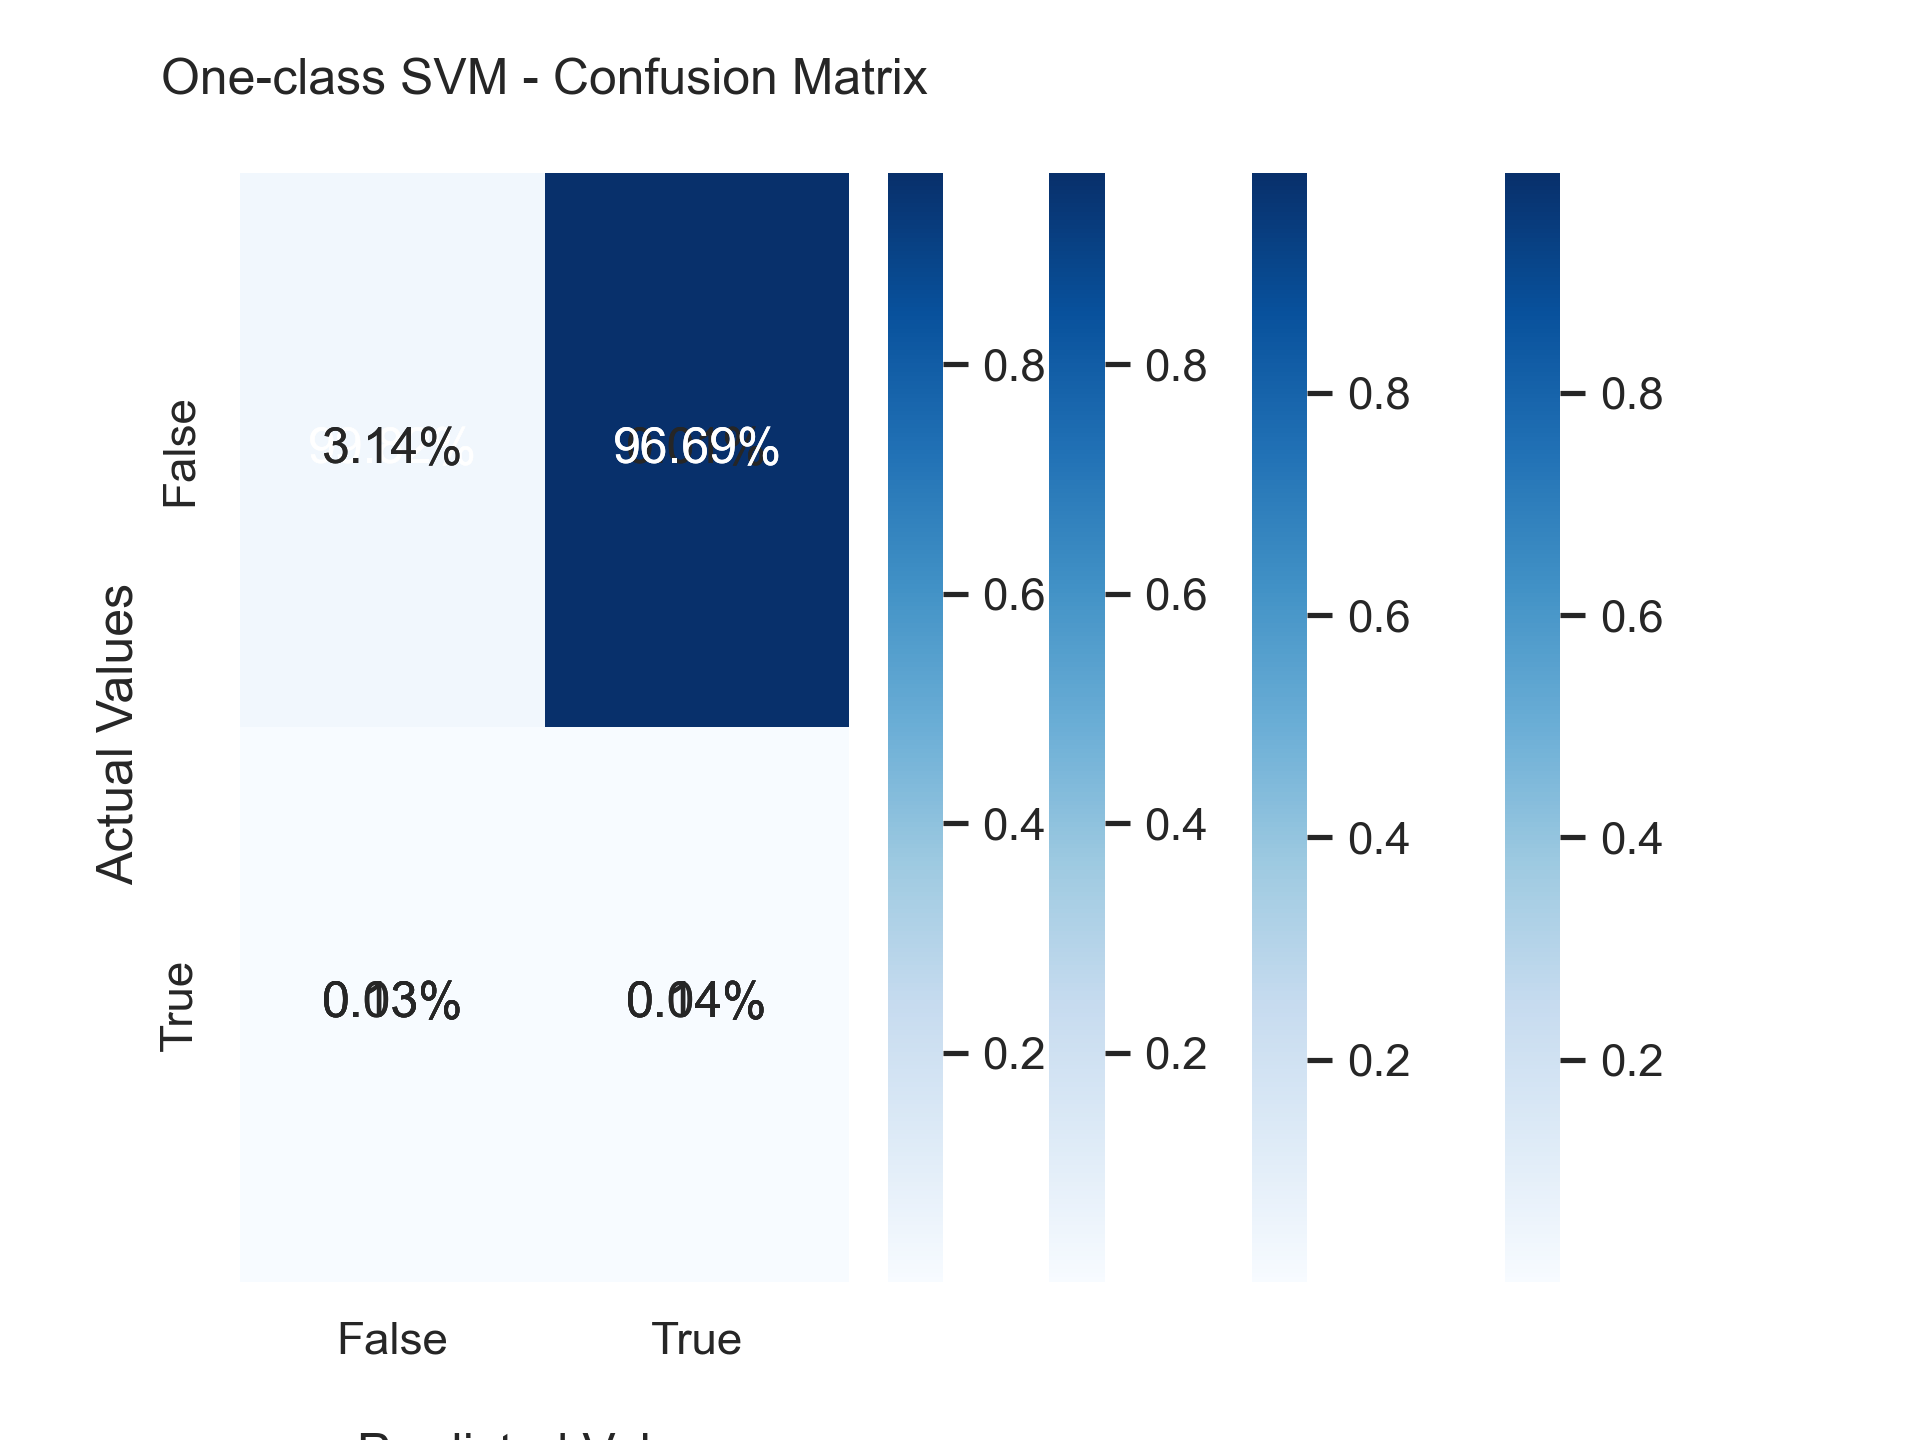

In [28]:
et=t.time()
print("Random Forest training time: %.3f"%(et-st))
# y_test=y_test.append(y_validate)
print("Accuracy score: ",accuracy_score(y_test,y_pred))

print("Data shape: ",y_test.shape, y_pred.shape)
print("Data type: ",type(y_test), type(y_pred))
M=confusion_matrix(y_test,y_pred)
M=M/M.sum()
print(M)
tn, fp, fn, tp = M.ravel()
print("TN: %.3f, FP: %.3f, FN: %.3f, TP: %.3f" %(tn,fp,fn,tp))
# ------------------

f1_val=f1_score(y_test,y_pred)
print("F1 score is: ",f1_val)

import seaborn as sns
ax = sns.heatmap(M, annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Random Forest - Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [54]:
X = df.iloc[:, 1:30]
y = df.iloc[:, 30:31]
y_pred = clf.predict(X)
M=confusion_matrix(y,y_pred)
print('We have detected ' + str(M[1][1]) + ' frauds / ' + str(M[1][1]+M[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(M[1][1]/(M[1][1]+M[1][0])))
print("the accuracy is : "+str((M[0][0]+M[1][1]) / (sum(M[0]) + sum(M[1]))))

We have detected 470 frauds / 492 total frauds.

So, the probability to detect a fraud is 0.9552845528455285
the accuracy is : 0.9999051989592952


In [29]:
THRESHOLD=3
print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{M}

% of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=3 are as follows:
[[9.98202298e-01 7.02227466e-05]
 [3.08980085e-04 1.41849948e-03]]

% of transactions labeled as fraud that were correct (precision): 0.0014184994803516755/(7.022274655206315e-05+0.0014184994803516755) = 95.28%
% of fraudulent transactions were caught succesfully (recall):    0.0014184994803516755/(0.00030898008482907783+0.0014184994803516755) = 82.11%
